In [1]:
import pandas as pd 
import json 
import copy
import re 
from pathlib import Path

from collections import Counter, defaultdict
from copy import deepcopy

pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',500)
from tqdm import tqdm
tqdm.pandas()
import string
from inflection import pluralize, singularize

from util_wordnet import get_sister_terms


# Convert the LM-Diagnostic-Extended data into LM probing format

{'vegetable', 'fish', 'bird', 'insect', 'flower', 'tree', 'building', 'tool', 'vehicle'}


,masked_sentences,obj_label,sub_label,sub_label_pl,relation,sub_sister,uuid
0,[A graver is a [MASK].],[tool],graver,gravers,IsA,"[bevel, dibber, spreader, hammer, crank, float, pallet, opener, starter, marlingspike, bodkin, plunger, auger, pincer, marlinspike, pick, tweezer, dibble, threader, square, saw, awl, marlinespike, screwdriver, pitchfork, pliers, sandblaster, file, plane, spatula, pointrel, trowel, weeder, wrench, gutter, scraper, spanner, shovel, pointel, plyers, straightedge, pestle, ravehook]",1
1,[A smallmouth is a [MASK].],[fish],smallmouth,smallmouths,IsA,[largemouth],2
2,[A pelican is a [MASK].],[bird],pelican,pelicans,IsA,"[cormorant, snakebird, tropicbird, darter, anhinga, gannet]",3
3,[A sapsucker is a [MASK].],[bird],sapsucker,sapsuckers,IsA,"[wryneck, redhead, piculet, ivorybill, flicker]",4
4,[A mako is a [MASK].],[fish],mako,makos,IsA,[porbeagle],5


#Hypo 576
#Hyper 9
#Hypo-Hyper pairs: 576
bird         0.229167
vehicle      0.182292
building     0.138889
fish         0.111111
tree         0.107639
flower       0.085069
insect       0.074653
tool         0.065972
vegetable    0.005208
Name: obj_label, dtype: float64


save ../../data/lm_diagnostic_extended//singular/IsA.jsonl with 576 lines
{'tools', 'fish', 'insects', 'vehicles', 'birds', 'trees', 'vegetables', 'flowers', 'buildings'}


,masked_sentences,obj_label,sub_label,sub_label_pl,relation,sub_sister,uuid
0,[gravers are [MASK].],[tools],gravers,gravers,IsA,"[bevel, dibber, spreader, hammer, crank, float, pallet, opener, starter, marlingspike, bodkin, plunger, auger, pincer, marlinspike, pick, tweezer, dibble, threader, square, saw, awl, marlinespike, screwdriver, pitchfork, pliers, sandblaster, file, plane, spatula, pointrel, trowel, weeder, wrench, graver, gutter, scraper, spanner, shovel, pointel, plyers, straightedge, pestle, ravehook]",1
1,[smallmouths are [MASK].],[fish],smallmouths,smallmouths,IsA,"[largemouth, smallmouth]",2
2,[pelicans are [MASK].],[birds],pelicans,pelicans,IsA,"[cormorant, snakebird, tropicbird, darter, anhinga, gannet, pelican]",3
3,[sapsuckers are [MASK].],[birds],sapsuckers,sapsuckers,IsA,"[wryneck, redhead, piculet, ivorybill, flicker, sapsucker]",4
4,[makoes are [MASK].],[fish],makoes,makoes,IsA,[],5


#Hypo 576
#Hyper 9
#Hypo-Hyper pairs: 576
birds         0.229167
vehicles      0.182292
buildings     0.138889
fish          0.111111
trees         0.107639
flowers       0.085069
insects       0.074653
tools         0.065972
vegetables    0.005208
Name: obj_label, dtype: float64


save ../../data/lm_diagnostic_extended//singular//plural/IsA.jsonl with 576 lines


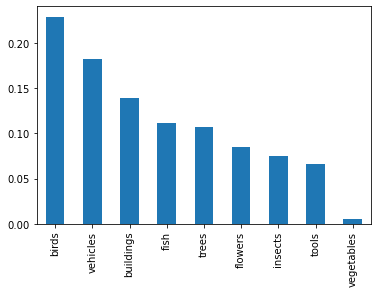

In [6]:
def _get_article(word):
    if word[0] in ['a', 'e', 'i', 'o', 'u']:
        return 'an'
    return 'a'


def save_dict_to_json(examples, output_path):
    ''' 
    save a list of dicts into otuput_path, orient='records' (each line is a dict) 
    examples: a list of dicts
    output_path: 
    '''

    with open(output_path, 'w') as fout:
        for example in examples:
            json.dump(example, fout)
            fout.write("\n")
        print(f"save {output_path} with {len(examples)} lines")

def add_period_at_the_end_of_sentence(sentence):
    last_token = sentence[-1]
    if last_token != '.': 
        return sentence + '.'
    return [sentence]

def process_data_to_lm():
    data_dir = '../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/' 
    out_dir = '../../data/lm_diagnostic_extended/'
    files = ['singular.tsv', 'plural.tsv'] #, 'contextual.tsv']

    for file in files: 
        path = f"{data_dir}/{file}"
        df = pd.read_csv(path, sep='\t', names=['masked_sentences', 'obj_label'])
        df['masked_sentences'] =  df['masked_sentences'].apply(lambda x: add_period_at_the_end_of_sentence(x))
        vocab = set(df['obj_label'].to_list())
        label_counter = df['obj_label'].value_counts(normalize=True)
        print(vocab)
        if 'singular' in file: 
             df['sub_label'] = df['masked_sentences'].apply(lambda x: x.split()[1])
        elif 'plural' in file: 
             df['sub_label'] = df['masked_sentences'].apply(lambda x: x.split()[0])
        
        word_pairs = [name for name, group in df.groupby(['sub_label', 'obj_label'])]
        hyper = set(df['obj_label'])
        df['sub_label_pl'] =  df['sub_label'].apply(lambda x: pluralize(x))
        df['obj_label'] =  df['obj_label'].apply(lambda x: [x])
        df['masked_sentences'] =  df['masked_sentences'].apply(lambda x: [x])
        df['relation'] = 'IsA'
        df['sub_sister'] = df['sub_label'].apply(lambda x: get_sister_terms(x, distance_to_hypernym=6))
        df['uuid'] = df.index + 1
        display(df.head())
        
        
        print(f"#Hypo {len(set(df['sub_label']))}")
        print(f"#Hyper {len(hyper)}")
        print(f"#Hypo-Hyper pairs:",len(word_pairs) )
        print(label_counter)
        display(label_counter.plot(kind='bar'))
        
        
        out_file = file.replace(".tsv", "")
        out_dir = f"{out_dir}/{out_file}/"
        Path( out_dir ).mkdir( parents=True, exist_ok=True )
        
        save_dict_to_json(examples=df.to_dict(orient='records'), output_path=out_dir + 'IsA.jsonl')     
process_data_to_lm()

# Merge the singular and plural obj label

In [14]:
def merge_anchors_in_concept_level(uniform_funcion, words, top_k):
    '''
    uniform_function: either signualr or plural
    
    '''
    top_k_output =  []
    for word in words:
        uniformed_words = uniform_funcion(word) 
        if word not in top_k_output: 
            top_k_output.append(word)
        if len(top_k_output) == top_k: 
            return top_k_output

    return top_k_output[:top_k]

words = ['ducks', 'duck', 'chickens', 'swans', 'hen', 'cranes', 'rabbits', 'brids', 'pigs'] 
merge_anchors_in_concept_level(singularize, words, 5)

['ducks', 'duck', 'chickens', 'swans', 'hen']

In [15]:
def merge_singular_plural_objects(singular, plural):
    return [singular] if singular == plural else [singular, plural]

def merge_singular_plural(data_dir = '../probe-generalization/Syntagmatic/LM-Diagnostic-Extended/' ):
    
    files = ['sgpl.tsv'] 

    for file in files: 
        path = f"{data_dir}/{file}"
        df = pd.read_csv(path, sep='\t', names=['masked_sentences', 'obj_label_singular', 'obj_label_plural'])
        df['masked_sentences'] =  df['masked_sentences'].apply(lambda x: add_period_at_the_end_of_sentence(x))
        
        
        df['sub_label'] = df['masked_sentences'].apply(lambda x: x.split()[1])
        df['sub_label_pl'] =  df['sub_label'].apply(lambda x: pluralize(x))
        df['sub_label_sg'] =  df['sub_label'].apply(lambda x: singularize(x))
        
        df['obj_label'] =  df[['obj_label_singular', 'obj_label_plural']].apply(lambda x: merge_singular_plural_objects(x[0], x[1]), axis=1)
#         vocab = set(df['obj_label'].to_list())
        df['masked_sentences'] =  df['masked_sentences'].apply(lambda x: [x])
        df['relation'] = 'IsA'
        df['uuid'] = df.index + 1
        
        df = df[['sub_label', 'obj_label', 'masked_sentences', 'uuid', 'relation', 'sub_label_pl', 'sub_label_sg']]
        display(df.head())
        out_file = file.replace(".tsv", "")
        out_dir = f"{data_dir}/{out_file}/"

        Path( out_dir ).mkdir( parents=True, exist_ok=True )
        save_dict_to_json(examples=df.to_dict(orient='records'), output_path=out_dir+"IsA.jsonl") 

merge_singular_plural(data_dir = '../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/')

,sub_label,obj_label,masked_sentences,uuid,relation,sub_label_pl,sub_label_sg
0,graver,"[tool, tools]",[A graver is a [MASK].],1,IsA,gravers,graver
1,smallmouth,[fish],[A smallmouth is a [MASK].],2,IsA,smallmouths,smallmouth
2,pelican,"[bird, birds]",[A pelican is a [MASK].],3,IsA,pelicans,pelican
3,sapsucker,"[bird, birds]",[A sapsucker is a [MASK].],4,IsA,sapsuckers,sapsucker
4,mako,[fish],[A mako is a [MASK].],5,IsA,makos,mako


save ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended//sgpl/IsA.jsonl with 576 lines


In [16]:
# !scp Syntagmatic/LM-Diagnostic-Extended/plural/IsA.jsonl spartan:/home/chunhua/cogsci/DAP/data/lm_diagnostic_extended/plural/IsA.jsonl
!scp ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/singular/IsA.jsonl spartan:/home/chunhua/cogsci/DAP/data/lm_diagnostic_extended/singular/IsA.jsonl
# !scp ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/sgpl/IsA.jsonl spartan:/home/chunhua/cogsci/DAP/data/lm_diagnostic_extended/sgpl/IsA.jsonl
    

/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: line 104: bind: warning: line editing not enabled
IsA.jsonl                                     100%  224KB   5.9MB/s   00:00    


# Qualitive analysis on signular anchors and plural anchors

In [17]:
import pandas as pd 
import json 
import copy
import re 
from pathlib import Path

from collections import Counter, defaultdict
from copy import deepcopy

pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',500)
from tqdm import tqdm
tqdm.pandas()


from nltk.corpus import wordnet as wn
from inflection import singularize, pluralize 



def get_sister_terms(word):
    '''
    "Coordinate (sister) terms: share the same hypernym"
    "The sister relation is the usual one encountered when working with tree structures: sisters are word forms (either simple words or collocations) that are both immediate hyponyms of the same node"
    '''
    sister_terms = set()
    for synset in wn.synsets(word ,"n"):
        for hypernym in synset.hypernyms()[:1]:
            sister_synsets = hypernym.hyponyms()
            for sister_synset in sister_synsets:
                sister_names = [x.name() for x in sister_synset.lemmas()]
                sister_names_selected = [name.lower() for name in sister_names if len(name.split("_"))==1 and  len(name.split("-"))==1  and name!=word]
                sister_terms = sister_terms.union(set(sister_names_selected))
#                 print(sister_synset)
#                 print(sister_terms )
#                 print()
    return list(sister_terms)

# read the singular data
path_anchor_sg = '../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg.csv'
query_cols = ['sub_label', 'obj_label', 'subj_anchors', 'uuid']
df_sg  = pd.read_csv(path_anchor_sg)[query_cols]
df_sg['subj_anchors'] = df_sg['subj_anchors'].apply(lambda x: eval(x))

df_sg['subj_anchors'] = df_sg['subj_anchors'].progress_apply(lambda x: [singularize(word) for word in x])
df_sg['subj_sisters'] = df_sg['sub_label'].progress_apply(lambda x: get_sister_terms(x))


# read the plural data
path_anchor_pl = '../log/bert-large-uncased/lm_diagnostic_extended/plural/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv'
df_pl  = pd.read_csv(path_anchor_pl)[query_cols]


100%|██████████| 576/576 [00:00<00:00, 9974.36it/s]


In [18]:
df_pl['subj_anchors'] = df_pl['subj_anchors'].apply(lambda x: eval(x))
df_pl['subj_anchors'] = df_pl['subj_anchors'].apply(lambda x: [singularize(word) for word in x])


# df_sgpl.columns 
df_sgpl = pd.merge(df_sg, df_pl, on ='uuid', suffixes=('_sg', '_pl'))
df_sgpl[['sub_label_sg', 'sub_label_pl', 'obj_label_sg', 'obj_label_pl', 'subj_anchors_sg', 'subj_anchors_pl']].head(20)
df_sgpl[['sub_label_sg', 'sub_label_pl', 'obj_label_sg', 'obj_label_pl', 'subj_anchors_sg', 'subj_anchors_pl', 'subj_sisters']].head(20)

df_sgpl['anchor_sg_in_sisters'] = df_sgpl[['subj_anchors_sg', 'subj_sisters']].apply(lambda x: set(x[0]).intersection(set(x[1])), axis=1)
df_sgpl['anchor_pl_in_sisters'] = df_sgpl[['subj_anchors_sg', 'subj_sisters']].apply(lambda x: set(x[0]).intersection(set(x[1])), axis=1)

df_sgpl['anchor_sg_in_sisters_num'] =  df_sgpl['anchor_sg_in_sisters'].apply(lambda x: len(x))  
df_sgpl['anchor_pl_in_sisters_num'] =  df_sgpl['anchor_pl_in_sisters'].apply(lambda x: len(x))  

# df_sgpl.head()
print(df_sgpl[['anchor_sg_in_sisters_num', 'anchor_pl_in_sisters_num']].describe())
print(df_sgpl[['anchor_sg_in_sisters_num', 'anchor_pl_in_sisters_num']].mean())

df_sgpl.to_csv("../log/anchors/lm_diagnostic_extended.anchors.csv")
# plot(kind='hist')

       anchor_sg_in_sisters_num  anchor_pl_in_sisters_num
count                576.000000                576.000000
mean                   0.258681                  0.258681
std                    0.657342                  0.657342
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    4.000000                  4.000000
anchor_sg_in_sisters_num    0.258681
anchor_pl_in_sisters_num    0.258681
dtype: float64


OSError: Cannot save file into a non-existent directory: '../log/anchors'

In [ ]:
!scp spartan:~/cogsci/DAP/log/anchors/lm_diagnostic_extended.anchors.csv ../log/bert-large-uncased/lm_diagnostic_extended/

In [ ]:
x1 = ['shovel', 'digger', 'deeper', 'grave', 'hammer']

In [7]:
df_sgpl = pd.read_csv('../log/bert-large-uncased/lm_diagnostic_extended/lm_diagnostic_extended.anchors.csv')
# for x in df_sgpl['subj_anchors_pl']:
#     print(type(eval(x)), eval(x))
# # df_sgpl.head()


for col in ['subj_anchors_sg', 'subj_sisters', 'subj_anchors_pl' ] :#'obj_label_sg', 'subj_anchors_sg',
#        'subj_sisters', 'obj_label_pl', 'subj_anchors_pl']:
#     print(col)
    df_sgpl[col] = df_sgpl[col].apply(lambda x: eval(x))
 

df_sgpl['anchor_sg_in_sisters'] = df_sgpl[['subj_anchors_sg', 'subj_sisters']].apply(lambda x: set(x[0]).intersection(set(x[1])), axis=1)
df_sgpl['anchor_pl_in_sisters'] = df_sgpl[['subj_anchors_pl', 'subj_sisters']].apply(lambda x: set(x[0]).intersection(set(x[1])), axis=1)


df_sgpl['anchor_sg_in_sisters_num'] =  df_sgpl['anchor_sg_in_sisters'].apply(lambda x: len(x))  
df_sgpl['anchor_pl_in_sisters_num'] =  df_sgpl['anchor_pl_in_sisters'].apply(lambda x: len(x))  


print(df_sgpl[['anchor_sg_in_sisters_num', 'anchor_pl_in_sisters_num']].describe())
print(df_sgpl[['anchor_sg_in_sisters_num', 'anchor_pl_in_sisters_num']].mean())

df_sgpl1 = df_sgpl.query("anchor_sg_in_sisters_num>0")
df_sgpl2 = df_sgpl.query("anchor_pl_in_sisters_num>0")
# df.columns
# df_sgpl[['subj_sisters', 'subj_anchors_sg', 'subj_anchors_pl', 'anchor_sg_in_sisters','anchor_pl_in_sisters',
#        'anchor_sg_in_sisters_num', 'anchor_pl_in_sisters_num']].head(50)
print(len(df_sgpl1))
print(len(df_sgpl2))

       anchor_sg_in_sisters_num  anchor_pl_in_sisters_num
count                576.000000                576.000000
mean                   0.255208                  0.526042
std                    0.650731                  1.061262
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  1.000000
max                    4.000000                  5.000000
anchor_sg_in_sisters_num    0.255208
anchor_pl_in_sisters_num    0.526042
dtype: float64
96
149


# Prcess data for consitency pair check

1. DEF-SAP '
`A(a) X is a(n) Y.`


2. X are Y.
DEF-DAP

A(n) X or Z is a(n) Y.
X or Z are Y.

LSP-SAP
Y such as X.
Y such as X.
LSP-DAP
Y such as X or Z.
Y such as X or Z.


In [11]:

def definition_sap_singular_plural(data_dir, file):
   
    path = f"{data_dir}/{file}"
    df = pd.read_csv(path, sep='\t', names=['mask_sentences_singular', 'obj_label_singular', 
                                            'mask_sentences_plural', 'obj_label_plural'])
    
    df['mask_sentences_singular'] =  df['mask_sentences_singular'].apply(lambda x: add_period_at_the_end_of_sentence(x))
    df['mask_sentences_plural'] =  df['mask_sentences_plural'].apply(lambda x: add_period_at_the_end_of_sentence(x))


    df['sub_label_singular'] = df['mask_sentences_singular'].apply(lambda x: x.split()[1])
    df['sub_label_plural'] = df['mask_sentences_plural'].apply(lambda x: x.split()[0])


    df['relation'] = 'IsA'
    df['uuid'] = df.index + 1


    df = df[['sub_label_singular', 'obj_label_singular', 'mask_sentences_singular', 
             'sub_label_plural', 'obj_label_plural', 'mask_sentences_plural', 
             'uuid', 'relation']]
    display(df.head())
    out_file = file.replace(".tsv", "")
    out_dir = f"{data_dir}/{out_file}/"

    Path( out_dir ).mkdir( parents=True, exist_ok=True )
    save_dict_to_json(examples=df.to_dict(orient='records'), output_path=out_dir+"IsA.jsonl") 
    return df 



def definition_dap_singular_plural(df):
    df['mask_sentences_singular'] = df[['sub_label_singular', 'mask_sentences_singular']].apply(lambda x: x[1].replace(x[0], f"{x[0]} or [Z]"), axis=1)
    df['mask_sentences_plural'] = df[['sub_label_plural', 'mask_sentences_plural']].apply(lambda x: x[1].replace(x[0], f"{x[0]} or [Z]"), axis=1)

    df = df[['sub_label_singular', 'obj_label_singular', 'mask_sentences_singular', 
            'sub_label_plural', 'obj_label_plural', 'mask_sentences_plural', 
             'uuid', 'relation']]

    return df 

def lsp_sap_singular_plural(df):
    '''
    sap: Y such as X 

    '''
    
    df['mask_sentences_singular'] = df['sub_label_singular'].apply(lambda x: f"[MASK] such as {_get_article(x)} {x}.")
   
    df['mask_sentences_plural'] = df['sub_label_plural'].apply(lambda x:f"[MASK] such as {x}.")

    df = df[['sub_label_singular', 'obj_label_singular', 'mask_sentences_singular', 
            'sub_label_plural', 'obj_label_plural', 'mask_sentences_plural', 
             'uuid', 'relation']]

    return df 


def lsp_dap_singular_plural(df):
    '''
    sap: Y such as X 

    '''
    df['mask_sentences_singular'] = df['sub_label_singular'].apply(lambda x: f"[MASK] such as {_get_article(x)} {x} or [Z].")

    df['mask_sentences_plural'] = df['sub_label_plural'].apply(lambda x:f"[MASK] such as {x} or [Z].")

    df = df[['sub_label_singular', 'obj_label_singular', 'mask_sentences_singular', 
            'sub_label_plural', 'obj_label_plural', 'mask_sentences_plural', 
             'uuid', 'relation']]

    return df 

def read_anchors(path, uniform_function=None):
    df = pd.read_csv(path)
    df['subj_anchors'] = df['subj_anchors'].apply(lambda x: eval(x))
    
    if uniform_function is not None: 
        df['subj_anchors'] = df['subj_anchors'].progress_apply(lambda x: [uniform_function(word) for word in x])
    return dict(zip(df['sub_label'], df['subj_anchors']))


In [25]:
from inflection import singularize, pluralize



def read_anchors(path_sg, path_pl, anchor_source, debug=False):
    '''
    read the anchor files mined from singualr and plural
    
    args: 
        anchor_soure: using the anchors mined from singular probe or plural probe
        
    return: 
        dic_sub_to_anchors_singular: both sub_label and subj_anchors are singular 
        dic_sub_to_anchors_plural: both sub_label and subj_anchors are plural 
    '''
    dfsg = pd.read_csv(path_sg)
    dfsg['subj_anchors'] = dfsg['subj_anchors'].apply(lambda x: eval(x))
    
    dfpl = pd.read_csv(path_pl)
    dfpl['subj_anchors'] = dfpl['subj_anchors'].apply(lambda x: eval(x))
    
    df = pd.merge(dfsg, dfpl, on = 'uuid', suffixes=('_sg', '_pl'))
    
    if debug: df = df.head(5)
        
    if anchor_source == 'plural':
        #convert the singular anchors into singular format
        df['subj_anchors_sg'] = df['subj_anchors_pl'].progress_apply(lambda x: [singularize(word) for word in x])
    elif anchor_source == 'singular':
        #convert the plural anchors into singular format
        df['subj_anchors_pl'] = df['subj_anchors_sg'].progress_apply(lambda x: [pluralize(word) for word in x])

    dic_sub_to_anchors_singular = dict(zip(df['sub_label_sg'], df['subj_anchors_sg']))
    dic_sub_to_anchors_plural = dict(zip(df['sub_label_pl'], df['subj_anchors_pl']))
    
    return dic_sub_to_anchors_singular, dic_sub_to_anchors_plural


path_anchor_sg = '../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg.csv'

path_anchor_pl = '../log/bert-large-uncased/lm_diagnostic_extended/plural/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv'

dic_sub_to_anchors_singular,dic_sub_to_anchors_plural = read_anchors(path_anchor_sg, path_anchor_pl, anchor_source='plural', debug=False)


 44%|████▍     | 253/576 [00:05<00:06, 46.87it/s]


KeyboardInterrupt: 

In [23]:
def insert_anchors(dic_sub_to_anchors, df, mask_col, sub_col, anchor_col, probe_type, article_for_z=False):
    df[mask_col].head()
    df[anchor_col] = df[sub_col].apply(lambda x: dic_sub_to_anchors.get(x) )
    
    if probe_type =='plural':
        df[mask_col] =  df[[anchor_col, mask_col]].apply(lambda x: [ x[1].replace('[Z]', anchor)  for anchor in x[0]], axis=1)
    elif probe_type == 'singular':
        if article_for_z: 
           df[mask_col] =  df[[anchor_col, mask_col]].apply(lambda x: [ x[1].replace('[Z]', "{} {}".format(_get_article(anchor), anchor))  for anchor in x[0]], axis=1) 
        else:
            df[mask_col] =  df[[anchor_col, mask_col]].apply(lambda x: [ x[1].replace('[Z]', anchor)  for anchor in x[0]], axis=1) 
            
    return df 


# create the dataset 
data_dir = '../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/' 
file = 'singular_plural.tsv'
df_def_sap = definition_sap_singular_plural(data_dir, file)
df_def_dap = definition_dap_singular_plural(deepcopy(df_def_sap))
df_lsp_sap = lsp_sap_singular_plural(deepcopy(df_def_sap))
df_lsp_dap = lsp_dap_singular_plural(deepcopy(df_def_sap))

display(df_def_sap.head())
display(df_def_dap.head())
display(df_lsp_sap.head())
display(df_lsp_dap.head())

df_def_dap = insert_anchors(dic_sub_to_anchors=dic_sub_to_anchors_singular, df= df_def_dap, mask_col = 'mask_sentences_singular', sub_col = 'sub_label_singular', anchor_col='subj_anchors_singular', probe_type='singular',article_for_z=False)

df_lsp_dap = insert_anchors(dic_sub_to_anchors=dic_sub_to_anchors_singular, df= df_lsp_dap, mask_col = 'mask_sentences_singular', sub_col = 'sub_label_singular', anchor_col='subj_anchors_singular', probe_type = 'singular', article_for_z=False)

df_lsp_dap[['sub_label_singular', 'subj_anchors_singular', 'mask_sentences_singular']].head() #''



# dic_sub_to_anchors_plural = read_anchors(path_anchor_pl)
df_def_dap = insert_anchors(dic_sub_to_anchors=dic_sub_to_anchors_plural, df= df_def_dap, mask_col = 'mask_sentences_plural', sub_col = 'sub_label_plural', anchor_col='subj_anchors_plural', probe_type='plural')

df_lsp_dap = insert_anchors(dic_sub_to_anchors=dic_sub_to_anchors_plural, df= df_lsp_dap, mask_col = 'mask_sentences_plural', sub_col = 'sub_label_plural', anchor_col='subj_anchors_plural', probe_type='plural')

df_lsp_dap[['sub_label_plural', 'subj_anchors_plural', 'mask_sentences_plural']].head() #''


# save files 
out_dir = '../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency/'
save_dict_to_json(examples=df_def_sap.to_dict(orient='records'), output_path=out_dir + 'IsA.def_sap.jsonl') 
save_dict_to_json(examples=df_def_dap.to_dict(orient='records'), output_path=out_dir + 'IsA.def_dap.jsonl') 
save_dict_to_json(examples=df_lsp_sap.to_dict(orient='records'), output_path=out_dir + 'IsA.lsp_sap.jsonl') 
save_dict_to_json(examples=df_lsp_dap.to_dict(orient='records'), output_path=out_dir + 'IsA.lsp_dap.jsonl') 


df_def_sap.to_csv(out_dir + 'IsA.def_sap.csv') 
df_def_dap.to_csv(out_dir + 'IsA.def_dap.csv') 
df_lsp_sap.to_csv(out_dir + 'IsA.lsp_sap.csv') 
df_lsp_dap.to_csv(out_dir + 'IsA.lsp_dap.csv')
df_lsp_dap.head()

,sub_label_singular,obj_label_singular,mask_sentences_singular,sub_label_plural,obj_label_plural,mask_sentences_plural,uuid,relation
0,graver,tool,A graver is a [MASK].,gravers,tools,gravers are [MASK].,1,IsA
1,smallmouth,fish,A smallmouth is a [MASK].,smallmouths,fish,smallmouths are [MASK].,2,IsA
2,pelican,bird,A pelican is a [MASK].,pelicans,birds,pelicans are [MASK].,3,IsA
3,sapsucker,bird,A sapsucker is a [MASK].,sapsuckers,birds,sapsuckers are [MASK].,4,IsA
4,mako,fish,A mako is a [MASK].,makoes,fish,makoes are [MASK].,5,IsA


save ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended//singular_plural/IsA.jsonl with 576 lines


,sub_label_singular,obj_label_singular,mask_sentences_singular,sub_label_plural,obj_label_plural,mask_sentences_plural,uuid,relation
0,graver,tool,A graver is a [MASK].,gravers,tools,gravers are [MASK].,1,IsA
1,smallmouth,fish,A smallmouth is a [MASK].,smallmouths,fish,smallmouths are [MASK].,2,IsA
2,pelican,bird,A pelican is a [MASK].,pelicans,birds,pelicans are [MASK].,3,IsA
3,sapsucker,bird,A sapsucker is a [MASK].,sapsuckers,birds,sapsuckers are [MASK].,4,IsA
4,mako,fish,A mako is a [MASK].,makoes,fish,makoes are [MASK].,5,IsA


,sub_label_singular,obj_label_singular,mask_sentences_singular,sub_label_plural,obj_label_plural,mask_sentences_plural,uuid,relation
0,graver,tool,A graver or [Z] is a [MASK].,gravers,tools,gravers or [Z] are [MASK].,1,IsA
1,smallmouth,fish,A smallmouth or [Z] is a [MASK].,smallmouths,fish,smallmouths or [Z] are [MASK].,2,IsA
2,pelican,bird,A pelican or [Z] is a [MASK].,pelicans,birds,pelicans or [Z] are [MASK].,3,IsA
3,sapsucker,bird,A sapsucker or [Z] is a [MASK].,sapsuckers,birds,sapsuckers or [Z] are [MASK].,4,IsA
4,mako,fish,A mako or [Z] is a [MASK].,makoes,fish,makoes or [Z] are [MASK].,5,IsA


,sub_label_singular,obj_label_singular,mask_sentences_singular,sub_label_plural,obj_label_plural,mask_sentences_plural,uuid,relation
0,graver,tool,[MASK] such as a graver.,gravers,tools,[MASK] such as gravers.,1,IsA
1,smallmouth,fish,[MASK] such as a smallmouth.,smallmouths,fish,[MASK] such as smallmouths.,2,IsA
2,pelican,bird,[MASK] such as a pelican.,pelicans,birds,[MASK] such as pelicans.,3,IsA
3,sapsucker,bird,[MASK] such as a sapsucker.,sapsuckers,birds,[MASK] such as sapsuckers.,4,IsA
4,mako,fish,[MASK] such as a mako.,makoes,fish,[MASK] such as makoes.,5,IsA


,sub_label_singular,obj_label_singular,mask_sentences_singular,sub_label_plural,obj_label_plural,mask_sentences_plural,uuid,relation
0,graver,tool,[MASK] such as a graver or [Z].,gravers,tools,[MASK] such as gravers or [Z].,1,IsA
1,smallmouth,fish,[MASK] such as a smallmouth or [Z].,smallmouths,fish,[MASK] such as smallmouths or [Z].,2,IsA
2,pelican,bird,[MASK] such as a pelican or [Z].,pelicans,birds,[MASK] such as pelicans or [Z].,3,IsA
3,sapsucker,bird,[MASK] such as a sapsucker or [Z].,sapsuckers,birds,[MASK] such as sapsuckers or [Z].,4,IsA
4,mako,fish,[MASK] such as a mako or [Z].,makoes,fish,[MASK] such as makoes or [Z].,5,IsA


save ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency/IsA.def_sap.jsonl with 576 lines
save ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency/IsA.def_dap.jsonl with 576 lines
save ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency/IsA.lsp_sap.jsonl with 576 lines
save ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency/IsA.lsp_dap.jsonl with 576 lines


,sub_label_singular,obj_label_singular,mask_sentences_singular,sub_label_plural,obj_label_plural,mask_sentences_plural,uuid,relation,subj_anchors_singular,subj_anchors_plural
0,graver,tool,"[[MASK] such as a graver or marker., [MASK] such as a graver or tomb., [MASK] such as a graver or grave., [MASK] such as a graver or body., [MASK] such as a graver or murderer.]",gravers,tools,"[[MASK] such as gravers or markers., [MASK] such as gravers or tombs., [MASK] such as gravers or graves., [MASK] such as gravers or bodies., [MASK] such as gravers or murderers.]",1,IsA,"[marker, tomb, grave, body, murderer]","[markers, tombs, graves, bodies, murderers]"
1,smallmouth,fish,"[[MASK] such as a smallmouth or catfish., [MASK] such as a smallmouth or carp., [MASK] such as a smallmouth or bass., [MASK] such as a smallmouth or pike., [MASK] such as a smallmouth or perch.]",smallmouths,fish,"[[MASK] such as smallmouths or catfish., [MASK] such as smallmouths or carp., [MASK] such as smallmouths or bass., [MASK] such as smallmouths or pike., [MASK] such as smallmouths or perch.]",2,IsA,"[catfish, carp, bass, pike, perch]","[catfish, carp, bass, pike, perch]"
2,pelican,bird,"[[MASK] such as a pelican or dolphin., [MASK] such as a pelican or penguin., [MASK] such as a pelican or duck., [MASK] such as a pelican or crane., [MASK] such as a pelican or eagle.]",pelicans,birds,"[[MASK] such as pelicans or dolphins., [MASK] such as pelicans or penguins., [MASK] such as pelicans or ducks., [MASK] such as pelicans or cranes., [MASK] such as pelicans or eagles.]",3,IsA,"[dolphin, penguin, duck, crane, eagle]","[dolphins, penguins, ducks, cranes, eagles]"
3,sapsucker,bird,"[[MASK] such as a sapsucker or snake., [MASK] such as a sapsucker or spider., [MASK] such as a sapsucker or frog., [MASK] such as a sapsucker or monster., [MASK] such as a sapsucker or lizard.]",sapsuckers,birds,"[[MASK] such as sapsuckers or snakes., [MASK] such as sapsuckers or spiders., [MASK] such as sapsuckers or frogs., [MASK] such as sapsuckers or monsters., [MASK] such as sapsuckers or lizards.]",4,IsA,"[snake, spider, frog, monster, lizard]","[snakes, spiders, frogs, monsters, lizards]"
4,mako,fish,"[[MASK] such as a mako or human., [MASK] such as a mako or tribe., [MASK] such as a mako or slave., [MASK] such as a mako or man., [MASK] such as a mako or peter.]",makoes,fish,"[[MASK] such as makoes or human., [MASK] such as makoes or tribe., [MASK] such as makoes or slaves., [MASK] such as makoes or man., [MASK] such as makoes or peter.]",5,IsA,"[human, tribe, slave, man, peter]","[human, tribe, slaves, man, peter]"


In [24]:
!scp -r ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency spartan:/home/chunhua/cogsci/DAP/data/lm_diagnostic_extended/
# !ls ../
# df_lsp_sap.head()
# df_lsp_dap.head()

/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: line 104: bind: warning: line editing not enabled
IsA.def_sap.csv                               100%   50KB   5.7MB/s   00:00    
IsA.lsp_dap.jsonl                             100%  422KB  65.5MB/s   00:00    
IsA.lsp_sap.csv                               100%   53KB  32.7MB/s   00:00    
IsA.def_sap.jsonl                             100%  148KB  60.3MB/s   00:00    
IsA.def_dap.jsonl                             100%  403KB  69.7MB/s   00:00    
IsA.lsp_sap.jsonl                             100%  152KB  69.2MB/s   00:00    
IsA.lsp_dap-checkpoint.csv                    100%  298KB  68.0MB/s   00:00    
IsA.def_dap-checkpoint.csv                    100%  284KB  72.9MB/s   00:00    
IsA.lsp_dap-checkpoint.jsonl                  100%  418KB  77.3MB/s   00:00    
IsA.lsp_sap-checkpoint.csv                    100%  148   156.9KB/s   00:00    
IsA.def_dap-checkpoint.jsonl                  100%  40

# Prepare data for checking group consistency 

In [44]:
lsp_sap = [
         "[Y] such as [X].", 
         "[Y], including [X].", 
         "[Y], especially [X].", 
         "[X] or other [Y].", 
         "[X] and other [Y].", 
         "such [Y] as [X].", 
        ]

lsp_dap = [
         "[Y] such as [X] and [Z].", 
         "[Y], including [X] and [Z].", 
         "[Y], especially [X] and [Z].", 
         "[X], [Z] and other [Y].", 
         "[X], [Z] or other [Y].", 
         "such [Y] as [X] and [Z]."]

def insert_anchors(dic_sub_to_anchors, df, mask_col, sub_col, anchor_col):
    df[mask_col].head()
    df[anchor_col] = df[sub_col].apply(lambda x: dic_sub_to_anchors.get(x) )
    df[mask_col] =  df[[anchor_col, mask_col]].apply(lambda x: [ x[1].replace('[Z]', anchor)  for anchor in x[0]], axis=1)
    return df

def fill_x_into_patterns(df, patterns, ):
    '''
    sap: Y such as X 

    '''
    
    for (i, pattern) in enumerate(patterns):
        pattern_id = i+1
        df[f'mask_sentences_singular_{pattern_id}'] = df['sub_label_singular'].apply(lambda x: pattern.replace("[X]", f"{_get_article(x)} {x}").replace("[Y]", '[MASK]'))
        df[f'mask_sentences_plural_{pattern_id}'] = df['sub_label_plural'].apply(lambda x: pattern.replace("[X]", x).replace("[Y]", '[MASK]'))
        
    mask_sentences_sg_cols = [x for x in df.columns if 'mask_sentences_singular_' in x]
    mask_sentences_pl_cols = [x for x in df.columns if 'mask_sentences_plural_' in x]
    return df, mask_sentences_sg_cols, mask_sentences_pl_cols



# read the data, fill x into the placeholder and fill Y with [MASK]
data_dir = '../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/' 
file = 'singular_plural.tsv'

df_def_sap = definition_sap_singular_plural(data_dir, file)
df_lsp_sap,mask_sentences_sg_cols, mask_sentences_pl_cols = fill_x_into_patterns(deepcopy(df_def_sap), patterns=lsp_sap)
df_lsp_dap,mask_sentences_sg_cols, mask_sentences_pl_cols = fill_x_into_patterns(deepcopy(df_def_sap), patterns=lsp_dap)

# read the anchors 
# path = '../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg.csv'

# dic_sub_to_anchors_singular = read_anchors(path)

# path = '../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/anchors.plural.csv'
# dic_sub_to_anchors_plural = read_anchors(path_anchor_pl)

# fill Z with real anchors 
for mask_col in mask_sentences_sg_cols:
    df_lsp_dap = insert_anchors(dic_sub_to_anchors=dic_sub_to_anchors_singular, df= df_lsp_dap, mask_col = mask_col, sub_col = 'sub_label_singular', anchor_col='subj_anchors_singular')

for mask_col in mask_sentences_pl_cols:
    df_lsp_dap = insert_anchors(dic_sub_to_anchors=dic_sub_to_anchors_plural, df= df_lsp_dap, mask_col = mask_col, sub_col = 'sub_label_plural', anchor_col='subj_anchors_plural')

# # save files 
output_cols = ['sub_label_singular', 'obj_label_singular','sub_label_plural', 'obj_label_plural',  'uuid',
       'relation', 
       'mask_sentences_singular_1', 'mask_sentences_singular_2', 'mask_sentences_singular_3', 
       'mask_sentences_singular_4', 'mask_sentences_singular_5', 'mask_sentences_singular_6',
       'mask_sentences_plural_1', 'mask_sentences_plural_2', 'mask_sentences_plural_3', 
       'mask_sentences_plural_4', 'mask_sentences_plural_5',  'mask_sentences_plural_6']

df_lsp_sap = df_lsp_sap[output_cols]
df_lsp_dap = df_lsp_dap[output_cols]
out_dir = '../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency_group/'
save_dict_to_json(examples=df_lsp_sap.to_dict(orient='records'), output_path=out_dir + 'IsA.lsp_sap.jsonl') 
save_dict_to_json(examples=df_lsp_dap.to_dict(orient='records'), output_path=out_dir + 'IsA.lsp_dap.jsonl') 
df_lsp_sap.to_csv(out_dir + 'IsA.lsp_sap.csv')
df_lsp_dap.to_csv(out_dir + 'IsA.lsp_dap.csv')
display(df_lsp_sap.head())
display(df_lsp_dap.head())

,sub_label_singular,obj_label_singular,mask_sentences_singular,sub_label_plural,obj_label_plural,mask_sentences_plural,uuid,relation
0,graver,tool,A graver is a [MASK].,gravers,tools,gravers are [MASK].,1,IsA
1,smallmouth,fish,A smallmouth is a [MASK].,smallmouths,fish,smallmouths are [MASK].,2,IsA
2,pelican,bird,A pelican is a [MASK].,pelicans,birds,pelicans are [MASK].,3,IsA
3,sapsucker,bird,A sapsucker is a [MASK].,sapsuckers,birds,sapsuckers are [MASK].,4,IsA
4,mako,fish,A mako is a [MASK].,makoes,fish,makoes are [MASK].,5,IsA


save ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended//singular_plural/IsA.jsonl with 576 lines
save ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency_group/IsA.lsp_sap.jsonl with 576 lines
save ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency_group/IsA.lsp_dap.jsonl with 576 lines


,sub_label_singular,obj_label_singular,sub_label_plural,obj_label_plural,uuid,relation,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,mask_sentences_singular_4,mask_sentences_singular_5,mask_sentences_singular_6,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6
0,graver,tool,gravers,tools,1,IsA,[MASK] such as a graver.,"[MASK], including a graver.","[MASK], especially a graver.",a graver or other [MASK].,a graver and other [MASK].,such [MASK] as a graver.,[MASK] such as gravers.,"[MASK], including gravers.","[MASK], especially gravers.",gravers or other [MASK].,gravers and other [MASK].,such [MASK] as gravers.
1,smallmouth,fish,smallmouths,fish,2,IsA,[MASK] such as a smallmouth.,"[MASK], including a smallmouth.","[MASK], especially a smallmouth.",a smallmouth or other [MASK].,a smallmouth and other [MASK].,such [MASK] as a smallmouth.,[MASK] such as smallmouths.,"[MASK], including smallmouths.","[MASK], especially smallmouths.",smallmouths or other [MASK].,smallmouths and other [MASK].,such [MASK] as smallmouths.
2,pelican,bird,pelicans,birds,3,IsA,[MASK] such as a pelican.,"[MASK], including a pelican.","[MASK], especially a pelican.",a pelican or other [MASK].,a pelican and other [MASK].,such [MASK] as a pelican.,[MASK] such as pelicans.,"[MASK], including pelicans.","[MASK], especially pelicans.",pelicans or other [MASK].,pelicans and other [MASK].,such [MASK] as pelicans.
3,sapsucker,bird,sapsuckers,birds,4,IsA,[MASK] such as a sapsucker.,"[MASK], including a sapsucker.","[MASK], especially a sapsucker.",a sapsucker or other [MASK].,a sapsucker and other [MASK].,such [MASK] as a sapsucker.,[MASK] such as sapsuckers.,"[MASK], including sapsuckers.","[MASK], especially sapsuckers.",sapsuckers or other [MASK].,sapsuckers and other [MASK].,such [MASK] as sapsuckers.
4,mako,fish,makoes,fish,5,IsA,[MASK] such as a mako.,"[MASK], including a mako.","[MASK], especially a mako.",a mako or other [MASK].,a mako and other [MASK].,such [MASK] as a mako.,[MASK] such as makoes.,"[MASK], including makoes.","[MASK], especially makoes.",makoes or other [MASK].,makoes and other [MASK].,such [MASK] as makoes.


,sub_label_singular,obj_label_singular,sub_label_plural,obj_label_plural,uuid,relation,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,mask_sentences_singular_4,mask_sentences_singular_5,mask_sentences_singular_6,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6
0,graver,tool,gravers,tools,1,IsA,"[[MASK] such as a graver and marker., [MASK] such as a graver and tomb., [MASK] such as a graver and grafe., [MASK] such as a graver and body., [MASK] such as a graver and murderer.]","[[MASK], including a graver and marker., [MASK], including a graver and tomb., [MASK], including a graver and grafe., [MASK], including a graver and body., [MASK], including a graver and murderer.]","[[MASK], especially a graver and marker., [MASK], especially a graver and tomb., [MASK], especially a graver and grafe., [MASK], especially a graver and body., [MASK], especially a graver and murderer.]","[a graver, marker and other [MASK]., a graver, tomb and other [MASK]., a graver, grafe and other [MASK]., a graver, body and other [MASK]., a graver, murderer and other [MASK].]","[a graver, marker or other [MASK]., a graver, tomb or other [MASK]., a graver, grafe or other [MASK]., a graver, body or other [MASK]., a graver, murderer or other [MASK].]","[such [MASK] as a graver and marker., such [MASK] as a graver and tomb., such [MASK] as a graver and grafe., such [MASK] as a graver and body., such [MASK] as a graver and murderer.]","[[MASK] such as gravers and markers., [MASK] such as gravers and tombs., [MASK] such as gravers and graves., [MASK] such as gravers and bodies., [MASK] such as gravers and murderers.]","[[MASK], including gravers and markers., [MASK], including gravers and tombs., [MASK], including gravers and graves., [MASK], including gravers and bodies., [MASK], including gravers and murderers.]","[[MASK], especially gravers and markers., [MASK], especially gravers and tombs., [MASK], especially gravers and graves., [MASK], especially gravers and bodies., [MASK], especially gravers and murderers.]","[gravers, markers and other [MASK]., gravers, tombs and other [MASK]., gravers, graves and other [MASK]., gravers, bodies and other [MASK]., gravers, murderers and other [MASK].]","[gravers, markers or other [MASK]., gravers, tombs or other [MASK]., gravers, graves or other [MASK]., gravers, bodies or other [MASK]., gravers, murderers or other [MASK].]","[such [MASK] as gravers and markers., such [MASK] as gravers and tombs., such [MASK] as gravers and graves., such [MASK] as gravers and bodies., such [MASK] as gravers and murderers.]"
1,smallmouth,fish,smallmouths,fish,2,IsA,"[[MASK] such as a smallmouth and catfish., [MASK] such as a smallmouth and carp., [MASK] such as a smallmouth and bass., [MASK] such as a smallmouth and pike., [MASK] such as a smallmouth and perch.]","[[MASK], including a smallmouth and catfish., [MASK], including a smallmouth and carp., [MASK], including a smallmouth and bass., [MASK], including a smallmouth and pike., [MASK], including a smallmouth and perch.]","[[MASK], especially a smallmouth and catfish., [MASK], especially a smallmouth and carp., [MASK], especially a smallmouth and bass., [MASK], especially a smallmouth and pike., [MASK], especially a smallmouth and perch.]","[a smallmouth, catfish and other [MASK]., a smallmouth, carp and other [MASK]., a smallmouth, bass and other [MASK]., a smallmouth, pike and other [MASK]., a smallmouth, perch and other [MASK].]","[a smallmouth, catfish or other [MASK]., a smallmouth, carp or other [MASK]., a smallmouth, bass or other [MASK]., a smallmouth, pike or other [MASK]., a smallmouth, perch or other [MASK].]","[such [MASK] as a smallmouth and catfish., such [MASK] as a smallmouth and carp., such [MASK] as a smallmouth and bass., such [MASK] as a smallmouth and pike., such [MASK] as a smallmouth and perch.]","[[MASK] such as smallmouths and catfish

In [45]:
# !mkdir ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency_group/
!scp -r ../data/probe-generalization/Syntagmatic/LM-Diagnostic-Extended/consistency_group spartan:/home/chunhua/cogsci/DAP/data/lm_diagnostic_extended/

/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: line 104: bind: warning: line editing not enabled
IsA.lsp_dap.jsonl                             100% 1650KB  60.6MB/s   00:00    
IsA.lsp_sap.csv                               100%  215KB  38.0MB/s   00:00    
IsA.lsp_sap.jsonl                             100%  485KB  28.5MB/s   00:00    
IsA.lsp_sap-checkpoint.jsonl                  100%  536KB  64.6MB/s   00:00    
IsA.lsp_dap-checkpoint.jsonl                  100% 1762KB  85.4MB/s   00:00    
IsA.lsp_sap-checkpoint.csv                    100%  240KB  47.7MB/s   00:00    
IsA.lsp_dap.csv                               100% 1402KB  56.8MB/s   00:00    
